In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from mlflux.gotm import compute_MLD
import pandas as pd
from mlflux.gotm import read_vars

import matplotlib.dates as mdates
from datetime import datetime

%load_ext autoreload
%autoreload 3

In [8]:
from metrics import open_ds
dir = '/scratch/jw8736/gotm/ensem/2011-01-01_2020-01-01/'
year = 2015

method = 'kpp'; MINUTE = 10
folder = f'out_{method}_dt{MINUTE}_{year}/'
ds_bulk_kpp, ds_ann_mean_kpp, ds_ensem_mean_kpp, ds_kpp = open_ds(dir+folder, SUBSET=False)
method = 'kepsilon'; MINUTE = 10
folder = f'out_{method}_dt{MINUTE}_{year}/'
ds_bulk_ke, ds_ann_mean_ke, ds_ensem_mean_ke, ds_ke = open_ds(dir+folder, SUBSET=False)

In [9]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds_kpp = compute_MLD (ds_kpp)
    ds_bulk_kpp = compute_MLD (ds_bulk_kpp) 
    ds_ensem_mean_kpp = compute_MLD (ds_ensem_mean_kpp) 
    ds_ann_mean_kpp = compute_MLD (ds_ann_mean_kpp) 
    
with ProgressBar():
    ds_ke = compute_MLD (ds_ke)
    ds_bulk_ke = compute_MLD (ds_bulk_ke) 
    ds_ensem_mean_ke = compute_MLD (ds_ensem_mean_ke) 
    ds_ann_mean_ke = compute_MLD (ds_ann_mean_ke) 

[########################################] | 100% Completed | 5.06 sms
[########################################] | 100% Completed | 8.87 ss


In [5]:
####### Observations #########
obs_folder = '/scratch/jw8736/gotm/shared/'
ds_obs = xr.open_dataset(obs_folder + 'profs.nc')
ds_obs = ds_obs.rename({'temp':'T', 'salinity':'S'})
ds_obs = compute_MLD(ds_obs, 'density')
SST_obs = ds_obs.T.isel(z=-1).resample(t='1D').mean()
MLD_obs = ds_obs.MLD.resample(t='1D').mean()
# ds_obs.T.sel(t=slice('2012-01-01','2012-12-31')).plot(x='t', cmap='jet', vmin=vmin, vmax=vmax)

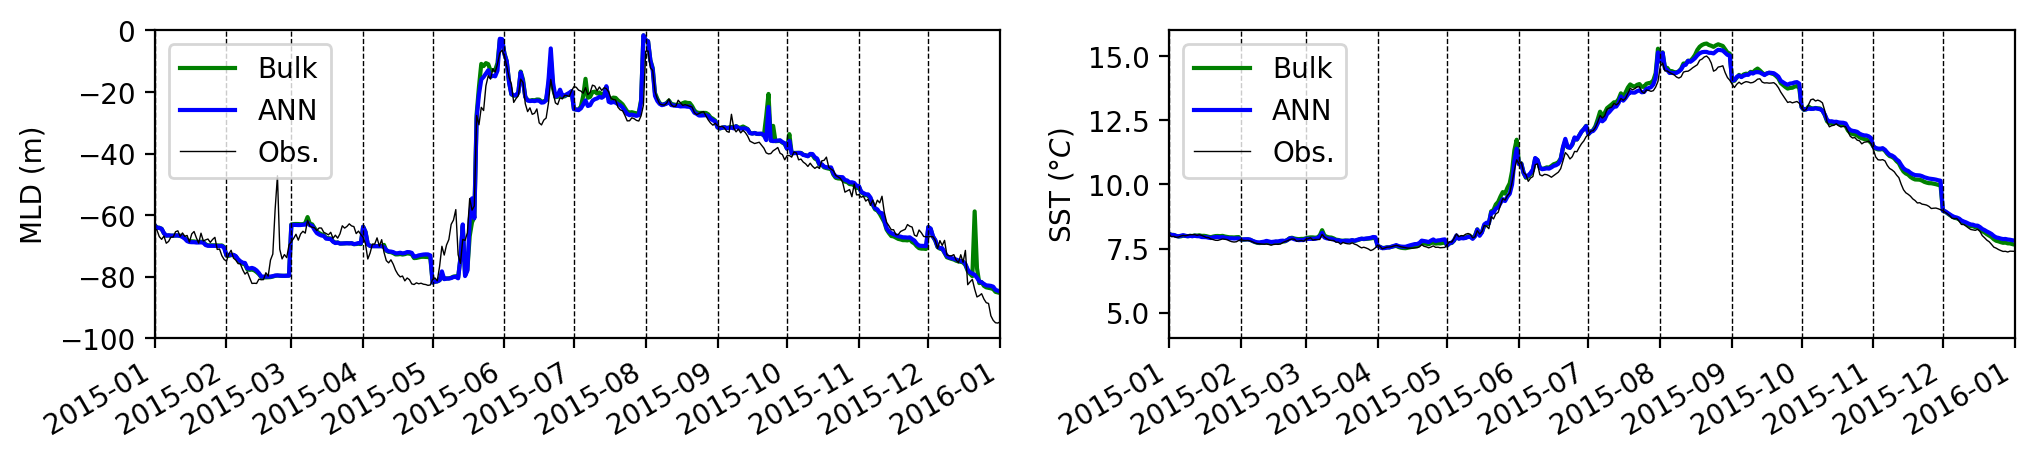

In [48]:
''' MLD smoothed to 12 hours. '''

def plot_deterministic (ds_bulk, ds_ann_mean):

    fig, axes = plt.subplots(1, 2, figsize=[12,2], dpi=200, sharex=True)
    
    ######### MLD ###########
    ds_bulk.MLD.resample(t='D').mean().plot(ax=axes[0], c='g', label='Bulk')
    ds_ann_mean.MLD.resample(t='D').mean().plot(ax=axes[0], c='b', label='ANN')

    MLD_obs.plot(ax=axes[0], c='k', label='Obs.', lw=0.5)
    axes[0].set_ylim([-100, 0])
    axes[0].set_xlabel(''); axes[0].set_ylabel('MLD (m)')
    
    ######### SST ###########
    ds_bulk.T.isel(z=-1).resample(t='D').mean().plot(ax=axes[1], label='Bulk', c='g')
    ds_ann_mean.T.isel(z=-1).resample(t='D').mean().plot(ax=axes[1], label='ANN', c='b')

    SST_obs.plot(ax=axes[1], c='k', label='Obs.', lw=0.5)
    axes[1].set_ylim([4,16])
    axes[1].set_title(''); axes[1].set_xlabel(''); axes[1].set_ylabel('SST ($\degree C$)')
    
    ######### Mark restart #######
    for i in range(1,13):
        axes[0].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')
        axes[1].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')
    
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[1].set_xlim([datetime(year, 1, 1), datetime(year+1, 1, 1)])
    
    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    
    return fig

# fig = plot_deterministic (ds_bulk_kpp, ds_ann_mean_kpp)
fig = plot_deterministic (ds_bulk_ke, ds_ann_mean_ke)
method = 'kepsilon'; MINUTE = 10; year = 2015
plt.savefig(f'../plots/MLD_SST_{method}{MINUTE}_{year}.png', bbox_inches='tight')

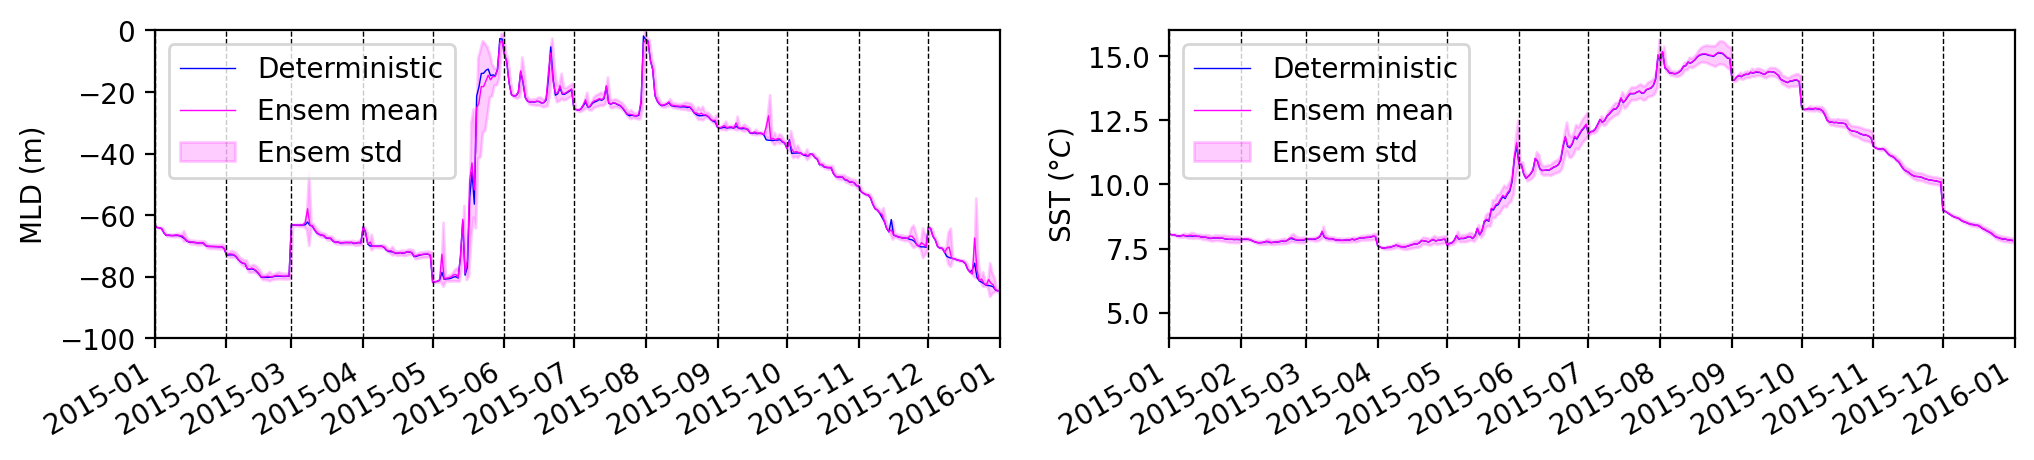

In [56]:
''' MLD smoothed to 12 hours. '''

def plot_stochastic (ds, ds_determ):

    fig, axes = plt.subplots(1, 2, figsize=[12,2], dpi=200, sharex=True)
    
    ######### MLD ###########
    # Individual stochastic member
    # for i in range(0,20,4):
    #     ds.isel(ensem=i).MLD.resample(t='D').mean().plot(ax=axes[0], lw=0.5, alpha=0.5, c='magenta')
      
    MLD_ensem_mean = ds.MLD.mean(dim='ensem').resample(t='D').mean()
    MLD_ensem_std = ds.MLD.std(dim='ensem').resample(t='D').mean()
    
    ds_determ.MLD.resample(t='D').mean().plot(ax=axes[0], c='b', label='Deterministic', lw=0.5)
    MLD_ensem_mean.plot(ax=axes[0], c='magenta', label='Ensem mean', lw=0.5)
    axes[0].fill_between(ds.t.resample(t='D').mean(), MLD_ensem_mean - MLD_ensem_std, MLD_ensem_mean + MLD_ensem_std, 
                         color='magenta', alpha=0.2, label='Ensem std')

    axes[0].set_ylim([-100, 0])
    axes[0].set_xlabel(''); axes[0].set_ylabel('MLD (m)')
    
    ######### SST ###########
    # Individual stochastic member
    # for i in range(0,20,4):
    #     ds.isel(ensem=i).T.isel(z=-1).resample(t='D').mean().plot(ax=axes[1], lw=0.5, alpha=0.5, c='magenta')
    
    SST_ensem_mean = ds.T.isel(z=-1).mean(dim='ensem').resample(t='D').mean()
    SST_ensem_std = ds.T.isel(z=-1).std(dim='ensem').resample(t='D').mean()

    ds_determ.T.isel(z=-1).resample(t='D').mean().plot(ax=axes[1], c='b', label='Deterministic', lw=0.5)
    SST_ensem_mean.plot(ax=axes[1], label='Ensem mean', c='magenta', lw=0.5)
    axes[1].fill_between(ds.t.resample(t='D').mean(), SST_ensem_mean - SST_ensem_std, SST_ensem_mean + SST_ensem_std, 
                         color='magenta', alpha=0.2, label='Ensem std')

    axes[1].set_ylim([4,16])
    axes[1].set_title(''); axes[1].set_xlabel(''); axes[1].set_ylabel('SST ($\degree C$)')
    
    ######### Mark restart #######
    for i in range(1,13):
        axes[0].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')
        axes[1].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')
    
    import matplotlib.dates as mdates
    from datetime import datetime
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[1].set_xlim([datetime(year, 1, 1), datetime(year+1, 1, 1)])
    
    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    
    return fig

fig = plot_stochastic (ds_ke, ds_ensem_mean_ke)
method = 'kepsilon'; MINUTE = 10; year = 2015
plt.savefig(f'../plots/MLD_SST_{method}{MINUTE}_{year}_stochastic.png', bbox_inches='tight')

### Used figure: illustration of profiles

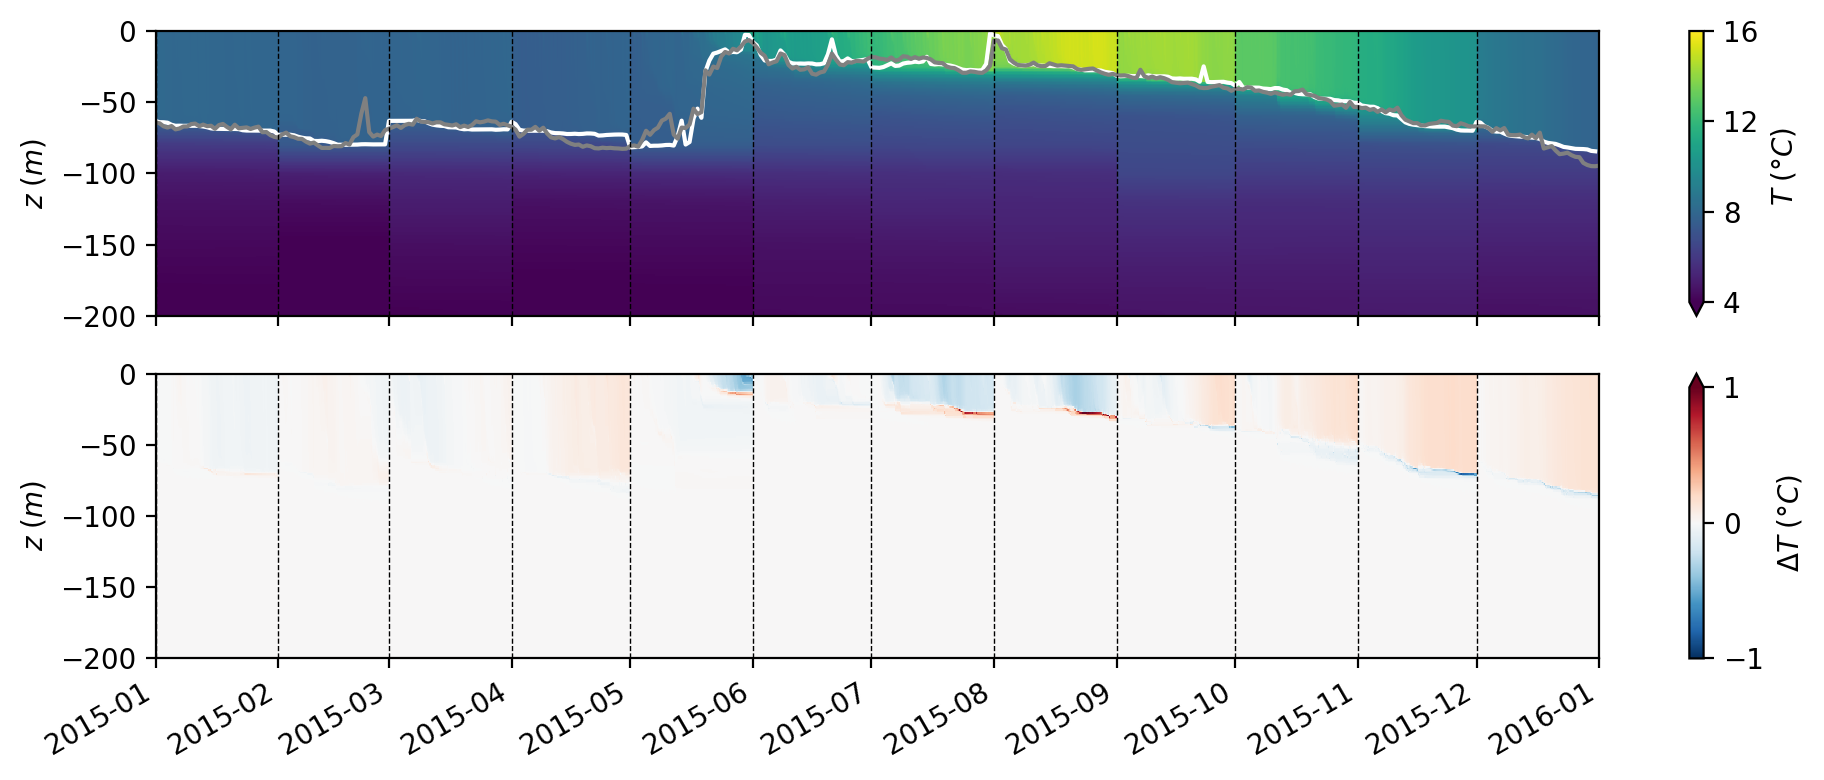

In [10]:
''' Plotting illustration:
    1. Temperature - with illustration of MLD
    2. Difference in temperature 
'''

def plot_prof (ds_bulk, ds_ann, ds_obs):
    fig, axes = plt.subplots(2, 1, figsize=[10,4], dpi=200, sharex=True)
    
    #### Plot heat fluxes
    # ds_mean2.Q.plot(x='t', c='b', ax=axes[0], lw=0.5)
    # ds_bulk.Q.plot(x='t', c='g', ax=axes[0], lw=0.5)
    # axes[0].set_ylabel(r'$Q_S + Q_L \; (W/m^2)$'); axes[0].set_xlabel('')
    # axes[0].set_ylim([-400,100)
    
    #### Plot temperature and MLD (daily mean)
    img1 = ds_ann.T.plot(ax=axes[0], x='t', cmap='viridis', vmin=4, vmax=16)
    ds_ann = compute_MLD(ds_ann, 'density')
    ds_ann.MLD.resample(t='D').mean().plot(ax=axes[0], c='w')
    ds_obs.MLD.resample(t='D').mean().plot(ax=axes[0], c='gray')
    img1.colorbar.set_label('$T \; (\degree C)$')
    img1.colorbar.set_ticks([4,8,12,16])
    
    #### Plot temperature difference
    T_diff = ds_ann.T - ds_bulk.T
    img2 = T_diff.plot(ax=axes[1], x='t', cmap='RdBu_r', vmin=-1, vmax=1)
    img2.colorbar.set_label('$\Delta T \; (\degree C)$')
    img2.colorbar.set_ticks([-1,0,1])
    
    #### Axes
    axes[0].set_ylabel('$z \; (m)$'); axes[0].set_xlabel('')
    axes[1].set_ylabel('$z \; (m)$'); axes[1].set_xlabel('')
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[1].set_xlim([datetime(year, 1, 1), datetime(year+1, 1, 1)])

    #### Add monthly restart lines
    for i in range(1,13):
        axes[0].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')
        axes[1].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')    
    plt.tight_layout()
    return fig

fig = plot_prof(ds_bulk_ke, ds_ann_mean_ke, ds_obs)
plt.savefig(f'../plots/tprof_{method}{MINUTE}_{year}.png', bbox_inches='tight')

### Validation plots

<Figure size 2400x800 with 0 Axes>

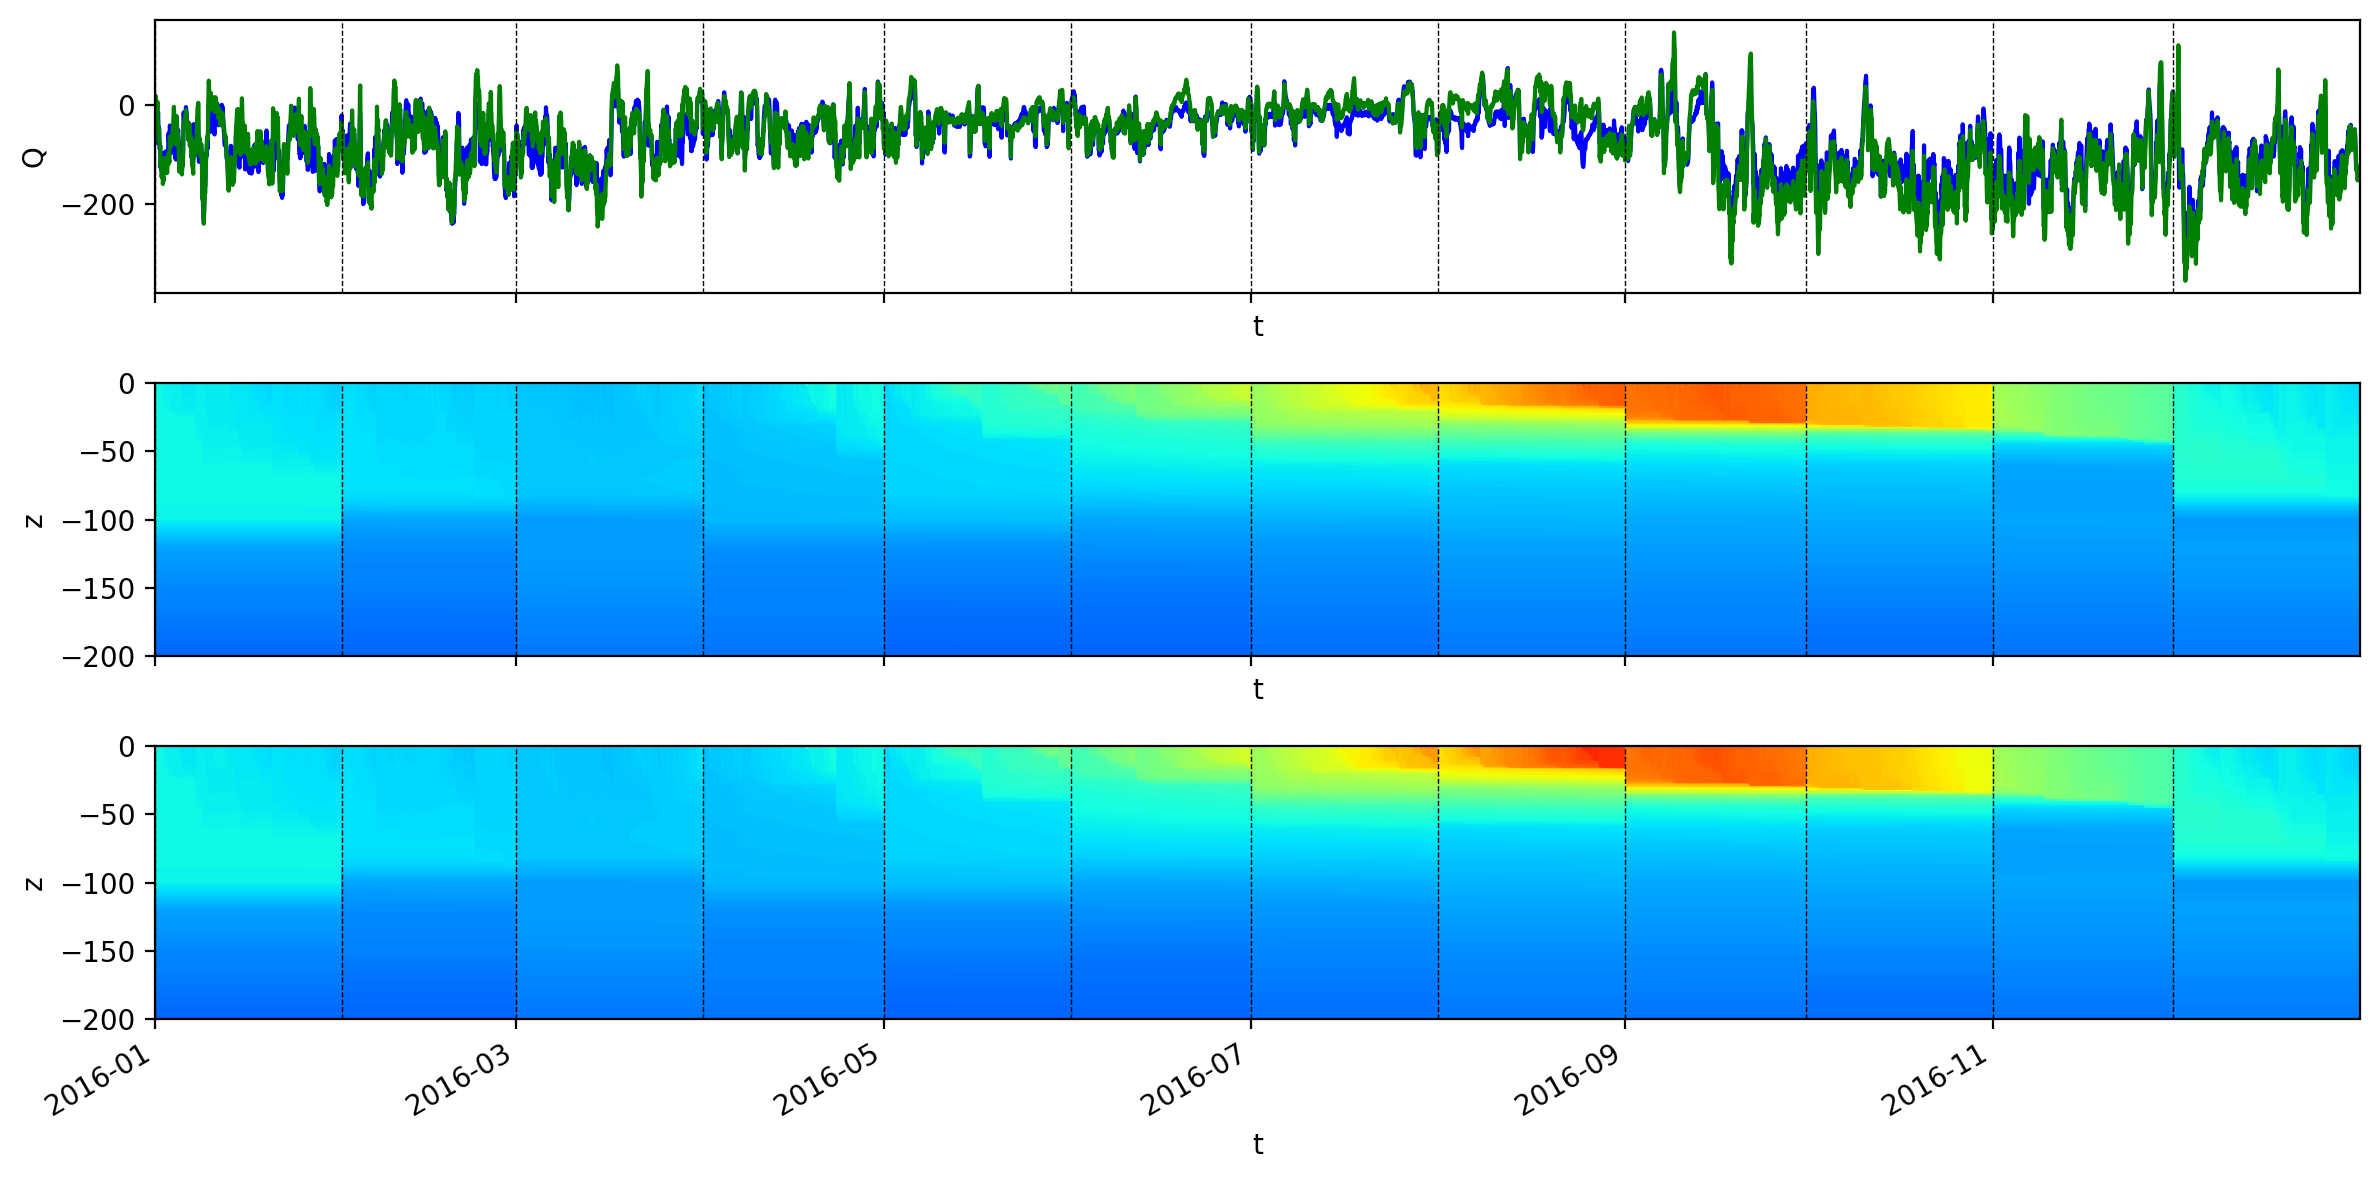

In [12]:
dir = '/scratch/jw8736/gotm/ensem/2011-01-01_2020-01-01/'

fig = plt.figure(figsize=[12,4], dpi=200)

year = 2016
method = 'kpp'
MINUTE = 60
folder = f'out_{method}_dt{MINUTE}_{year}/'
ds = xr.open_mfdataset(dir+folder+f'out_ensem*.nc', combine='nested', concat_dim='ensem')
ds_bulk = xr.open_dataset(dir+folder+'out_bulk.nc')
ds_mean1 = xr.open_dataset(dir+folder+'out_ensem_mean.nc')
ds_mean2 = xr.open_dataset(dir+folder+'out_ann_mean.nc')

fig, axes = plt.subplots(3, 1, figsize=[12,6], dpi=200, sharex=True)

ds_mean2.Q.plot(x='t', c='b', ax=axes[0])
ds_bulk.Q.plot(x='t', c='g', ax=axes[0])

vmin=0; vmax=20
ds_mean2.T.plot(ax=axes[1], x='t', cmap='jet', vmin=vmin, vmax=vmax, add_colorbar=False)
ds_bulk.T.plot(ax=axes[2], x='t', cmap='jet', vmin=vmin, vmax=vmax, add_colorbar=False)
for i in range(1,13):
    axes[0].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')
    axes[1].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')
    axes[2].axvline(x=pd.Timestamp(year,i,1), ls='--', lw=0.5, c='k')

plt.tight_layout();

### Check test run with only 1 month 


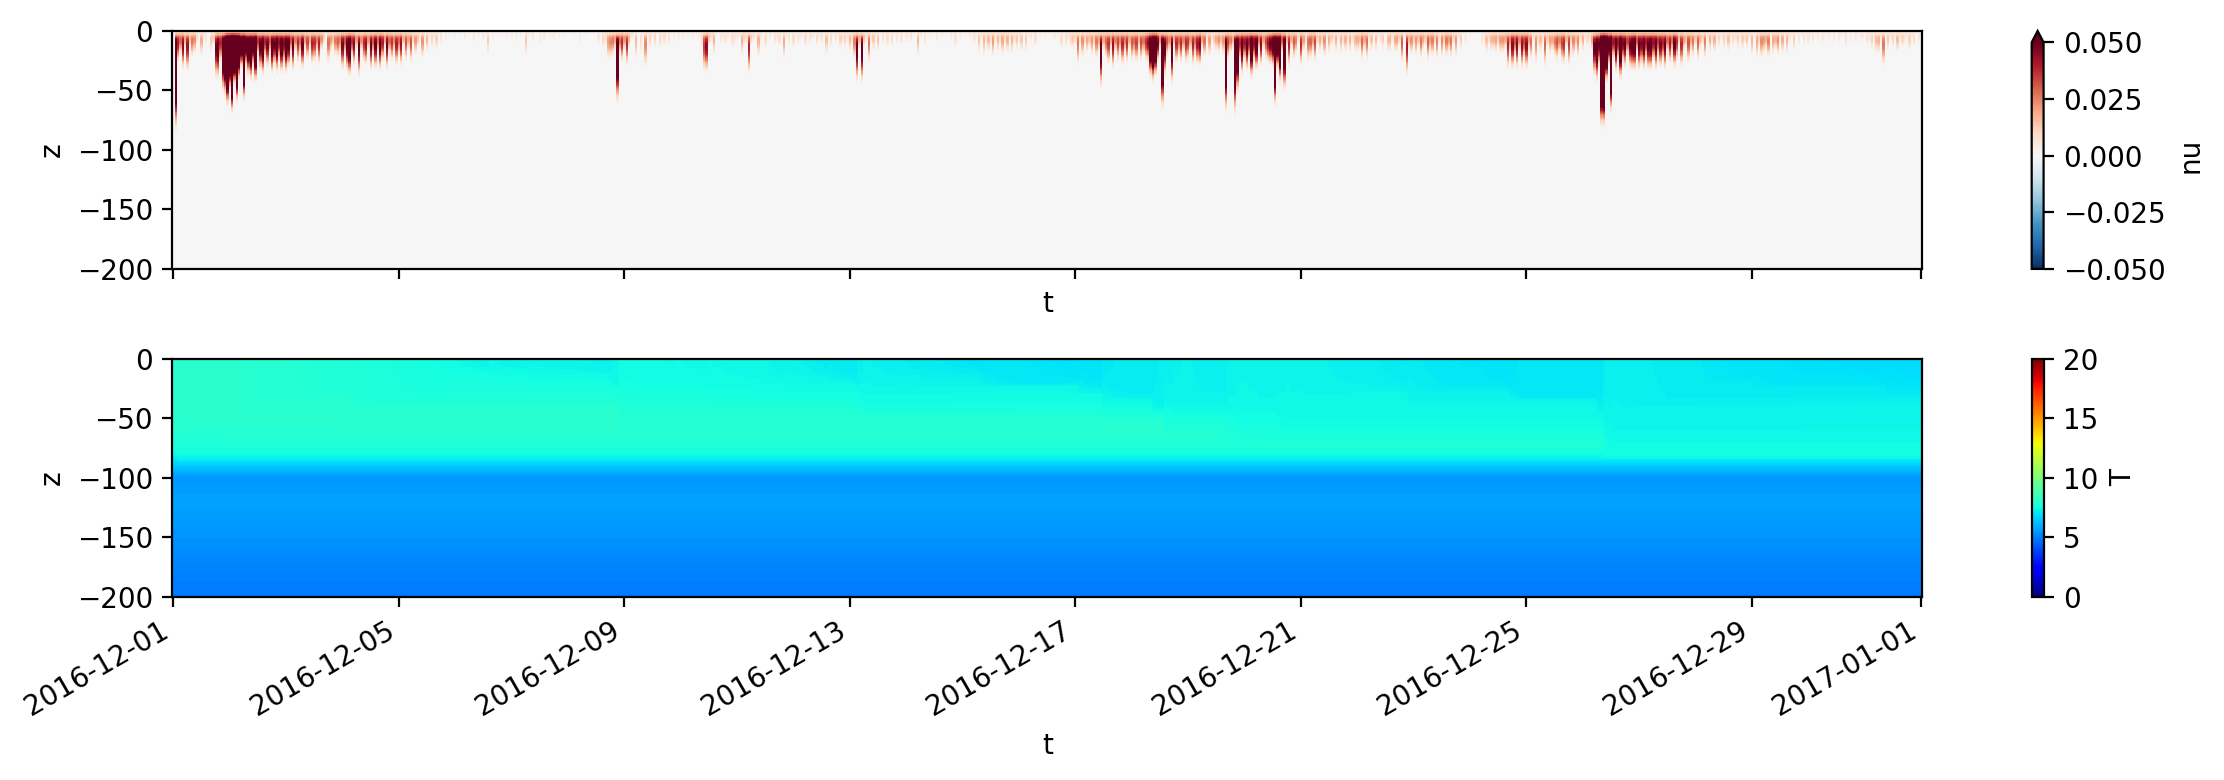

In [9]:
from mlflux.gotm import read

year = 2016
month = 12
method = 'kpp'
MINUTE = 60

n2 = 200 # number of vertical points
n1 = 31 # run for 31 days regardless of months
n1_ = int(n1*24*60/MINUTE) + 1 # depends on output frequency

folder = '/scratch/jw8736/gotm/ensem/test/'
filename = folder + 'out_dec_nointernal'
start_date = pd.Timestamp(year=year, month=month, day=1)
ds = read (filename, n1_, n2, start_date)

# T2 = ds.T.resample(t='30Min').mean()

fig, axes = plt.subplots(2, 1, figsize=[12,4], dpi=200, sharex=True)

ds.nu.plot(ax=axes[0], x='t', vmax=0.05, vmin=-0.05, cmap='RdBu_r')
ds.T.plot(ax=axes[1], x='t', vmin=0, vmax=20, cmap='jet')

plt.tight_layout();